In [1]:
from landlab.components import OverlandFlow, DetachmentLtdErosion, SinkFiller
from landlab.io import read_esri_ascii
from landlab import imshow_grid
import numpy as np
import copy
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

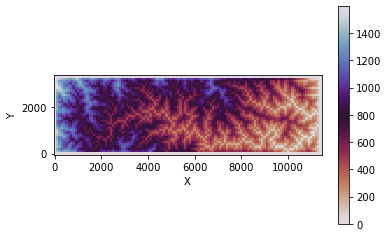

In [2]:
max_dt = 0.5  
tPlot = 500 # seconds

basin_flag = 'sam_dem' # 'Square' or Long'
storm_flag = 'Base' # 'Base' or'HigherIntensity' or 'LongerDuration'

if basin_flag == 'Square':
    watershed_dem = 'Square_TestBasin.asc'
    link_to_sample = 299
    node_to_sample = 300
elif basin_flag == 'Long':
    watershed_dem = 'Long_TestBasin.asc'
    link_to_sample = 149
    node_to_sample = 150
elif basin_flag == 'sam_dem':
    watershed_dem = 'steady_state.asc'
    link_to_sample = 1493
    node_to_sample = 1494

(rmg, z) = read_esri_ascii(watershed_dem, name='topographic__elevation')
imshow_grid(rmg, 'topographic__elevation', vmin=0, cmap='twilight_r')  # plots the DEM
plt.show()

rmg.set_watershed_boundary_condition_outlet_id((1493), z, -9999.)
z = np.where(z == 0, -9999.0, z)

sf = SinkFiller(rmg, routing='D4', apply_slope=True, fill_slope=1.e-5)
sf.fill_pits()
z_initial = copy.deepcopy(z)

rmg.set_watershed_boundary_condition(z)

In [3]:
print(OverlandFlow.input_var_names)
print(DetachmentLtdErosion.input_var_names)

('surface_water__depth', 'topographic__elevation')
('surface_water__discharge', 'topographic__elevation')


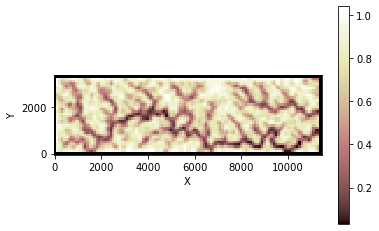

In [4]:
rmg.add_zeros('surface_water__depth', at = 'node')   
rmg.at_node['surface_water__depth'].fill(1.e-12)
rmg.add_zeros('surface_water__discharge', at='link')    # All cells are dry at the beginning of the simulation - no discharge

# I don't know if these variables are used
rmg['node']['surface_water__discharge'] = np.zeros(rmg.number_of_nodes)
rmg['node']['water_surface__slope'] = np.zeros(rmg.number_of_nodes)

# Also, DetachmentLtdErosion requires the calculation of the 'topographic__slope'
rmg.at_node['topographic__slope'] = rmg.calc_slope_at_node(elevs='topographic__elevation')
imshow_grid(rmg, 'topographic__slope');
plt.show()

In [5]:
# Initialization
of = OverlandFlow(rmg, mannings_n=0.03, steep_slopes=True, alpha = 0.3)   # instantiate OverlandFlow object
dle = DetachmentLtdErosion(rmg, K_sp = 1.259162261 * (10**-7)) #instantiate DetachmentLtdErosion object

* Now we set the boundary conditions, instantiate the components, and set the appropriate storm parameters.
  * All `NODATA` nodes in the DEM are closed boundaries and the outlet is set to an open boundary. This is all done in `rmg.set_watershed_boundary_condition(z)`.
 

In [6]:
if storm_flag == 'Base':
    starting_precip_mmhr = 20.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 200.
elif storm_flag == 'HigherIntensity':
    starting_precip_mmhr = 10.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 200.
elif storm_flag == 'LongerDuration':
    starting_precip_mmhr = 5.0
    starting_precip_ms = starting_precip_mmhr * (2.77778 * 10 ** -7)
    storm_duration = 14400.

* Before we go further, let's pause to look at the landscape that we will be routing flow over.

* Initialize a few more parameters, and getting ready to run the time loop and save data for plotting.
  * These two components take time steps in *seconds*

In [7]:
uplift_rate = 3.170979 * (10**-10) # m/s

elapsed_time = 1.0
model_run_time = 1500.0 # s

discharge_at_outlet = []
hydrograph_time = []
incision_at_outlet = []

* Let's run the time loop, that is, generate overland flow and erode!

Elapsed time : 500.5  s. Current dt = 0.5  s


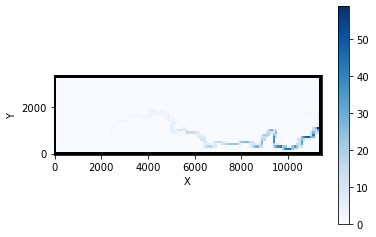

Elapsed time : 1000.5  s. Current dt = 0.5  s


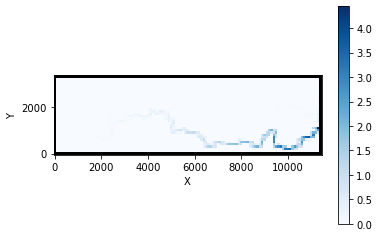

In [8]:
while elapsed_time < model_run_time:
    
    of.dt = min(max_dt,of.calc_time_step())
                
    if elapsed_time < (storm_duration):
        of.rainfall_intensity =  starting_precip_ms  
    else:
        of.rainfall_intensity = 0.0

    of.overland_flow()
    of.dt = min(max_dt,of.calc_time_step())
   
    node_slope = (of._water_surface_slope[rmg.links_at_node] * rmg.active_link_dirs_at_node)
    incision_Q = np.abs(of._q * rmg.dx)[rmg.links_at_node]
    rmg['node']['surface_water__discharge'] = (incision_Q[np.arange(len(node_slope)), np.argmax(node_slope, axis=1)])
   
    node_slope = node_slope.max(axis=1)
    rmg['node']['water_surface__slope'] = node_slope

    dle.run_one_step(of.dt)

    rmg['node']['topographic__elevation'] += uplift_rate * of.dt

    hydrograph_time.append(elapsed_time)
    discharge_at_outlet.append(np.abs(of._q[link_to_sample]) * rmg.dx)
    incision_at_outlet.append(dle._I[node_to_sample])

    tPlot = tPlot-of.dt
    if tPlot <= 0:
        print('Elapsed time :',elapsed_time,' s. Current dt =',of.dt,' s')
        imshow_grid(rmg, 'surface_water__discharge', cmap='Blues');
        plt.show()
       
        tPlot = 500

    elapsed_time += of.dt

* Let's look at the data.

Text(0.5, 1.0, 'Hydrograph at Watershed Outlet')

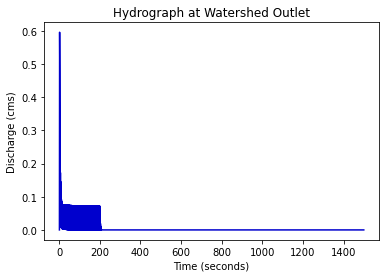

In [9]:
plt.figure(1)
plt.plot(hydrograph_time, discharge_at_outlet, color='mediumblue')
plt.ylabel('Discharge (cms)')
plt.xlabel('Time (seconds)')
plt.title('Hydrograph at Watershed Outlet')

# files = plt.savefig('HydrographAtBasinOutlet.png')

Text(0.5, 1.0, 'Incision at Watershed Outlet')

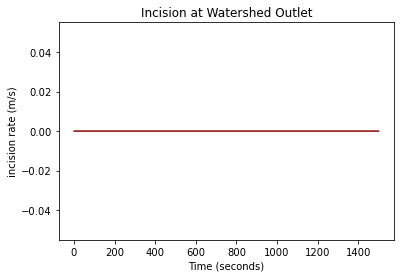

In [10]:
plt.figure(2)
plt.plot(hydrograph_time, incision_at_outlet, color='darkred')
plt.ylabel('incision rate (m/s)')
plt.xlabel('Time (seconds)')
plt.title('Incision at Watershed Outlet')

# files = plt.savefig('HydrographAtBasinOutlet.png')

* Let's look at the change in the topography, first including uplift.
  * The colorbar is limited to beter show patterns.
  * Because we didn't take out uplift, there are some locations in which elevation has actually increased.

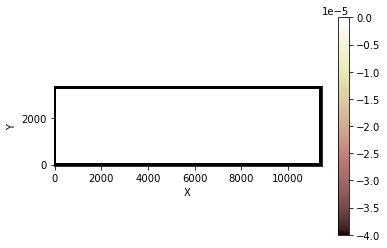

In [11]:
z_diff = z - z_initial # the difference in elevation from start to finish
imshow_grid(rmg, z_diff, limits=(-0.00004, np.max(z_diff)))  

* We can take out uplift in order to just look at incision rates and patterns.
  * We again limit the color bar to highlight patterns

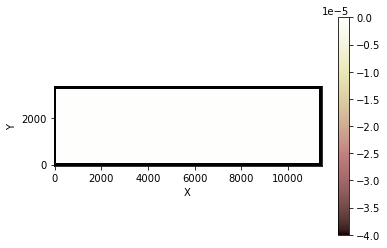

In [12]:
### this is just fluvial incision, which will be negative
z_diff = z - z_initial - uplift_rate * model_run_time 
imshow_grid(rmg, z_diff, limits=(-0.00004, 0.0))